## Linear Regression

### Import packages

In [23]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Loading training data from sklearn

In [24]:
# use data from sklearn package
def load_moons():
    from sklearn.datasets import make_moons
    np.random.seed(0)
    X, y = make_moons(800, noise=0.2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_circles():
    from sklearn.datasets import make_circles
    np.random.seed(0)
    X, y = make_circles(800, noise=0.2, factor=0.5, random_state=2)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_linear():
    from sklearn.datasets import make_classification
    np.random.seed(0)
    X, y = make_classification(
        800, n_features=2, n_redundant=0, n_informative=1,
        random_state=1, n_clusters_per_class=1)
    print ("dataset shape:", X.shape)
    
    # return train validate test sets 
    return [(X[0:600,],y[0:600,]), (X[600:800,],y[600:800,])]

def load_data(name='moons', load_directly=False):
    _datasets={
        'moons': load_moons,
        'linear': load_linear,
        'circles': load_circles,
    }
    try:
        ret = pickle.load(open('./{}.pkl'.format(name), 'r')) if load_directly else _datasets[name]()
    except Exception as e:
        print("set name as 'moons', 'linear' or 'circles',\n or check your files' existence")
        print(e)
    return ret

In [25]:
load_data()

dataset shape: (800, 2)


[(array([[-0.6163918 ,  1.05132077],
         [-1.56484155,  0.52800342],
         [-1.14463522, -0.22814069],
         ...,
         [ 1.23695873,  0.41959524],
         [ 0.67830608, -1.0233622 ],
         [ 0.55276083, -0.22725251]]),
  array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
         0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
         0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
         0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
         1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
         1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
         0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 

### Define network
> 以下是线性回归(Linear Regression)的神经网络结构

对于输入向量x，模型对于输入向量x的预测结果y_pred为：
$$y_{pred}=argmax_i\left ( Wx+b \right )$$

损失函数为y_pred和y的均方误差（MSE）：
$$L\left ( \theta =\left \{ W,b \right \},D \right )=\sum_{i=0}^{\left | D \right |}\left (y_{pred}^{\left ( i \right )}- y^{\left ( i \right )}  \right )^2$$

In [26]:
class LinearRegression():
    def __init__(self, n_in, n_out):
        self.X = tf.placeholder(tf.float32, [None, n_in], name='X')
        self.y = tf.placeholder(tf.int32, [None], name='y')
        self.init_variables(n_in, n_out)
        
    def init_variables(self, n_in, n_out):
        # n_in means n_features
        # n_out means n_classes
        self.W = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_in, n_out]),
            dtype=tf.float32, name='weight')
        self.b = tf.Variable(
            initial_value=tf.constant(0.0, shape=[n_out]),
            dtype=tf.float32, name='bias')
        
    def negative_log_likelihood(self, y_pred, y):
        prob = self.sigmoid(y_pred)
        positive_likelihood = tf.log(prob) * y.reshape(-1, 1)
        negative_likelihood = tf.log(1 - prob) * (1 - y.reshape(-1, 1))
        log_likelihood = positive_likelihood + negative_likelihood
        return -tf.reduce_mean(log_likelihood)
    
    def get_network(self):
        hidden = tf.matmul(self.X, self.W) + self.b
        
        # compute y_pred
        self.y_pred = tf.argmax(hidden, axis=-1)
        return self.y_pred, hidden
    
    def get_loss(self, hidden):
        onehot_labels = tf.one_hot(self.y, depth=2)
        
        # compute MSE(mean squared error),first compute square,then get its average
        return tf.reduce_mean(tf.square(onehot_labels - hidden))
    
    def gen_input(self, data_x, data_y=None):
        feed_dict = {}
        feed_dict[self.X] = data_x
        if data_y is not None:    
            self.y_truth = data_y
            feed_dict[self.y] = data_y
        return feed_dict
    
    def errors(self, y_pred, y_truth=None):
        if y_truth is None:
            y_truth = self.y
            not_equal_counts = tf.abs(y_pred - y_truth)
            return tf.reduce_mean(not_equal_counts)
        else:
            not_equal_counts = abs(y_pred - y_truth)
            return np.mean(not_equal_counts)

### Define optimizer

In [27]:
def sgd_optimization(datasets, learning_rate=0.10, n_epochs=50, draw_freq=10):
    train_set_x, train_set_y = datasets[0]
    test_set_x,  test_set_y  = datasets[1]
    classifier = LinearRegression(n_in=2, n_out=2)  # Classifier
    
    def get_model_train():
        with tf.name_scope('train'):
            y_pred, hidden = classifier.get_network()
            loss = classifier.get_loss(hidden)
            return y_pred, loss
    
    def get_model_test():
        with tf.name_scope('test'):
            y_pred, hidden = classifier.get_network()
            return y_pred
        
    train_output = get_model_train()  # y_pred, loss
    test_output = get_model_test()  # y_pred
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(train_output[-1])
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    def call_model(data_x, data_y=None, name=None):
        # generate data_y for placeholder while testing
        if data_y is None:
            data_y = np.zeros(data_x.shape[:-1])
            
        if name == 'test':
            ret = sess.run(  # return y_pred
                test_output,
                feed_dict=classifier.gen_input(data_x, data_y))
        else:  # name == 'train'
            _, ret = sess.run(  # return y_pred, loss
                [optimizer, train_output], 
                feed_dict=classifier.gen_input(data_x, data_y))
        return ret
    
    epoch = 0
    while epoch < n_epochs:
        # draw a figure every 'draw_freq' times
        if epoch % draw_freq == 0:
            # print(train_set_x, train_set_y)
            plot_decision_boundary(
                lambda x: call_model(x)[0], 
                train_set_x, train_set_y)
        
        # print error/cost per epoch
        train_pred, loss = call_model(
            train_set_x, train_set_y, 'train')
        train_error = classifier.errors(
            y_pred=train_pred, y_truth=train_set_y)
        
        test_pred = call_model(
            test_set_x,  test_set_y, 'test')
        test_error = classifier.errors(
            y_pred=test_pred, y_truth=test_set_y)

        print ("epoch is %d, train error %f, test error %f" % (
            epoch, train_error, test_error))
        epoch += 1

    # draw a figure at last        
    plot_decision_boundary(
        lambda x: call_model(x)[0], 
        train_set_x, train_set_y)
    sess.close()


def plot_decision_boundary(pred_func, train_set_x, train_set_y):
    # Draw figures as Matlab 
    x_min, x_max = train_set_x[:, 0].min() - .5, train_set_x[:, 0].max() + .5
    y_min, y_max = train_set_x[:, 1].min() - .5, train_set_x[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_input = np.c_[xx.ravel(), yy.ravel()].reshape([-1, 2])
    Z = pred_func(grid_input)
    plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.scatter(train_set_x[:, 0], train_set_x[:, 1], c=train_set_y, cmap=plt.cm.Spectral)
    plt.show()

### Start Training

dataset shape: (800, 2)


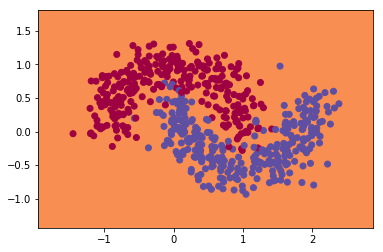

epoch is 0, train error 0.513333, test error 0.460000
epoch is 1, train error 0.513333, test error 0.140000
epoch is 2, train error 0.215000, test error 0.165000
epoch is 3, train error 0.215000, test error 0.185000
epoch is 4, train error 0.206667, test error 0.180000
epoch is 5, train error 0.196667, test error 0.180000
epoch is 6, train error 0.200000, test error 0.185000
epoch is 7, train error 0.200000, test error 0.180000
epoch is 8, train error 0.201667, test error 0.180000
epoch is 9, train error 0.201667, test error 0.180000
epoch is 10, train error 0.195000, test error 0.180000
epoch is 11, train error 0.193333, test error 0.180000
epoch is 12, train error 0.193333, test error 0.180000
epoch is 13, train error 0.193333, test error 0.175000
epoch is 14, train error 0.193333, test error 0.170000
epoch is 15, train error 0.190000, test error 0.170000
epoch is 16, train error 0.188333, test error 0.170000
epoch is 17, train error 0.188333, test error 0.170000
epoch is 18, train e

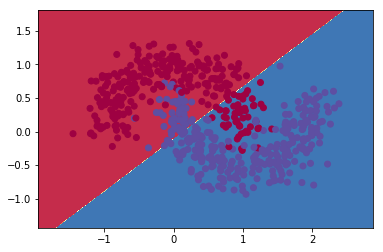

epoch is 25, train error 0.176667, test error 0.150000
epoch is 26, train error 0.176667, test error 0.150000
epoch is 27, train error 0.180000, test error 0.160000
epoch is 28, train error 0.180000, test error 0.160000
epoch is 29, train error 0.178333, test error 0.155000
epoch is 30, train error 0.181667, test error 0.150000
epoch is 31, train error 0.185000, test error 0.150000
epoch is 32, train error 0.185000, test error 0.150000
epoch is 33, train error 0.181667, test error 0.150000
epoch is 34, train error 0.181667, test error 0.150000
epoch is 35, train error 0.183333, test error 0.150000
epoch is 36, train error 0.180000, test error 0.150000
epoch is 37, train error 0.180000, test error 0.150000
epoch is 38, train error 0.176667, test error 0.145000
epoch is 39, train error 0.175000, test error 0.145000
epoch is 40, train error 0.175000, test error 0.145000
epoch is 41, train error 0.175000, test error 0.145000
epoch is 42, train error 0.175000, test error 0.145000
epoch is 4

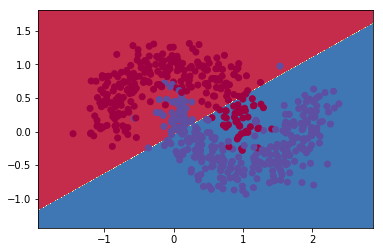

epoch is 50, train error 0.155000, test error 0.135000
epoch is 51, train error 0.155000, test error 0.135000
epoch is 52, train error 0.165000, test error 0.135000
epoch is 53, train error 0.168333, test error 0.135000
epoch is 54, train error 0.170000, test error 0.135000
epoch is 55, train error 0.170000, test error 0.135000
epoch is 56, train error 0.165000, test error 0.135000
epoch is 57, train error 0.161667, test error 0.140000
epoch is 58, train error 0.166667, test error 0.145000
epoch is 59, train error 0.165000, test error 0.145000
epoch is 60, train error 0.163333, test error 0.145000
epoch is 61, train error 0.160000, test error 0.145000
epoch is 62, train error 0.160000, test error 0.145000
epoch is 63, train error 0.160000, test error 0.145000
epoch is 64, train error 0.160000, test error 0.140000
epoch is 65, train error 0.160000, test error 0.140000
epoch is 66, train error 0.158333, test error 0.140000
epoch is 67, train error 0.156667, test error 0.140000
epoch is 6

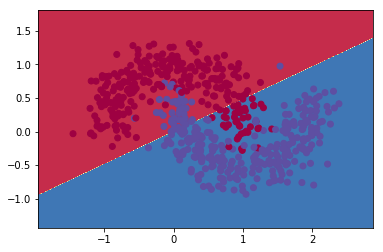

epoch is 75, train error 0.150000, test error 0.130000
epoch is 76, train error 0.148333, test error 0.135000
epoch is 77, train error 0.146667, test error 0.125000
epoch is 78, train error 0.156667, test error 0.130000
epoch is 79, train error 0.156667, test error 0.130000
epoch is 80, train error 0.153333, test error 0.130000
epoch is 81, train error 0.151667, test error 0.135000
epoch is 82, train error 0.153333, test error 0.135000
epoch is 83, train error 0.151667, test error 0.135000
epoch is 84, train error 0.151667, test error 0.135000
epoch is 85, train error 0.151667, test error 0.140000
epoch is 86, train error 0.153333, test error 0.140000
epoch is 87, train error 0.153333, test error 0.145000
epoch is 88, train error 0.153333, test error 0.140000
epoch is 89, train error 0.153333, test error 0.140000
epoch is 90, train error 0.153333, test error 0.140000
epoch is 91, train error 0.153333, test error 0.140000
epoch is 92, train error 0.153333, test error 0.140000
epoch is 9

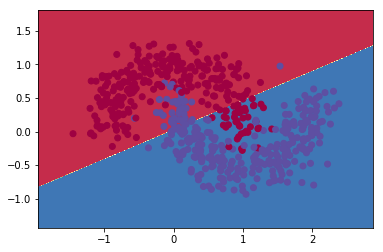

epoch is 100, train error 0.145000, test error 0.130000
epoch is 101, train error 0.143333, test error 0.130000
epoch is 102, train error 0.138333, test error 0.125000
epoch is 103, train error 0.145000, test error 0.130000
epoch is 104, train error 0.150000, test error 0.130000
epoch is 105, train error 0.148333, test error 0.130000
epoch is 106, train error 0.148333, test error 0.130000
epoch is 107, train error 0.146667, test error 0.135000
epoch is 108, train error 0.145000, test error 0.135000
epoch is 109, train error 0.148333, test error 0.135000
epoch is 110, train error 0.148333, test error 0.135000
epoch is 111, train error 0.148333, test error 0.135000
epoch is 112, train error 0.150000, test error 0.135000
epoch is 113, train error 0.153333, test error 0.135000
epoch is 114, train error 0.151667, test error 0.135000
epoch is 115, train error 0.150000, test error 0.135000
epoch is 116, train error 0.150000, test error 0.135000
epoch is 117, train error 0.150000, test error 0

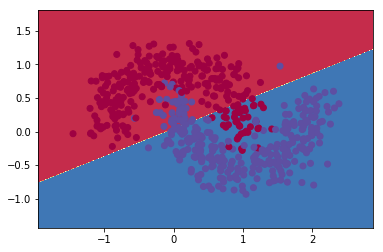

epoch is 125, train error 0.146667, test error 0.130000
epoch is 126, train error 0.140000, test error 0.125000
epoch is 127, train error 0.136667, test error 0.125000
epoch is 128, train error 0.140000, test error 0.125000
epoch is 129, train error 0.146667, test error 0.130000
epoch is 130, train error 0.145000, test error 0.130000
epoch is 131, train error 0.143333, test error 0.130000
epoch is 132, train error 0.145000, test error 0.135000
epoch is 133, train error 0.145000, test error 0.135000
epoch is 134, train error 0.146667, test error 0.135000
epoch is 135, train error 0.146667, test error 0.135000
epoch is 136, train error 0.145000, test error 0.135000
epoch is 137, train error 0.145000, test error 0.130000
epoch is 138, train error 0.145000, test error 0.130000
epoch is 139, train error 0.146667, test error 0.135000
epoch is 140, train error 0.146667, test error 0.135000
epoch is 141, train error 0.146667, test error 0.135000
epoch is 142, train error 0.146667, test error 0

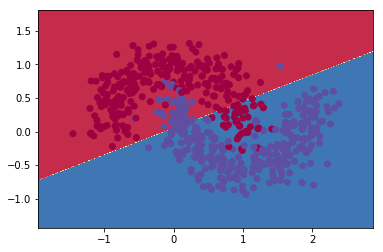

epoch is 150, train error 0.145000, test error 0.125000
epoch is 151, train error 0.138333, test error 0.125000
epoch is 152, train error 0.131667, test error 0.125000
epoch is 153, train error 0.138333, test error 0.125000
epoch is 154, train error 0.143333, test error 0.130000
epoch is 155, train error 0.143333, test error 0.130000
epoch is 156, train error 0.145000, test error 0.130000
epoch is 157, train error 0.145000, test error 0.130000
epoch is 158, train error 0.143333, test error 0.135000
epoch is 159, train error 0.143333, test error 0.135000
epoch is 160, train error 0.145000, test error 0.135000
epoch is 161, train error 0.145000, test error 0.130000
epoch is 162, train error 0.143333, test error 0.130000
epoch is 163, train error 0.141667, test error 0.130000
epoch is 164, train error 0.141667, test error 0.130000
epoch is 165, train error 0.143333, test error 0.135000
epoch is 166, train error 0.145000, test error 0.135000
epoch is 167, train error 0.143333, test error 0

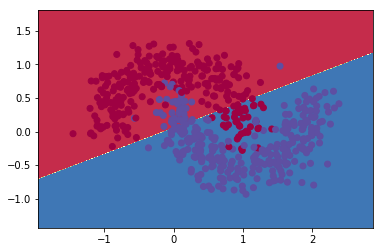

epoch is 175, train error 0.143333, test error 0.125000
epoch is 176, train error 0.138333, test error 0.125000
epoch is 177, train error 0.131667, test error 0.125000
epoch is 178, train error 0.138333, test error 0.125000
epoch is 179, train error 0.141667, test error 0.130000
epoch is 180, train error 0.143333, test error 0.130000
epoch is 181, train error 0.145000, test error 0.130000
epoch is 182, train error 0.143333, test error 0.130000
epoch is 183, train error 0.143333, test error 0.135000
epoch is 184, train error 0.143333, test error 0.135000
epoch is 185, train error 0.145000, test error 0.135000
epoch is 186, train error 0.143333, test error 0.130000
epoch is 187, train error 0.141667, test error 0.130000
epoch is 188, train error 0.141667, test error 0.130000
epoch is 189, train error 0.141667, test error 0.130000
epoch is 190, train error 0.141667, test error 0.135000
epoch is 191, train error 0.143333, test error 0.135000
epoch is 192, train error 0.143333, test error 0

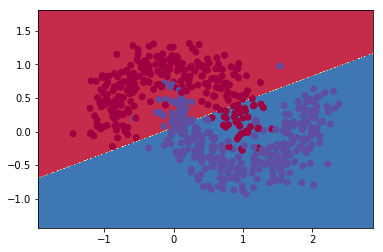

In [31]:
if __name__=="__main__":
    data = load_data('moons')
    sgd_optimization(data, learning_rate=0.1, n_epochs=200, draw_freq=25)